# Pancreas data for fig 3

In [36]:
# import third party packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import matplotlib as mpl
import imp
import sys
import requests
import os

# Make sure you can import northstar by adding its parent folder to your PYTHONPATH aka sys.path
sys.path.append('/Users/bojk/Documents/northstar/')
import northstar

# Make sure you can import the modules in the 'modules' folder by adding it to your PYTHONPATH aka sys.path
sys.path.append(os.path.abspath('.')+'/modules')
import northstar_analysis as noa
import northstar_sankey as nosa
import northstar_dotplot as ndot
import get_timestamp as time

In [37]:
!{sys.executable} -m pip install northstar


## make directories:

In [38]:
#input dir for new Pancreas data (which will be available somewhere upon publication)
input_dir = '/Users/bojk/Google Drive/QuakeLab/NorthStar/PancreasData/'  # Bojk's mac

#savedir_init = '/home/bojk/Data/SA_data/' # Bojk's linux 
savedir_init = '/Users/bojk/Google Drive/QuakeLab/NorthStar/'  # Bojk's mac
#savedir_init = os.path.abspath('.')+'/data/'
os.makedirs(savedir_init, exist_ok=True)

# Output folder for figures etc.
output_dir = savedir_init+'PancreasAnalysis/'
os.makedirs(output_dir, exist_ok=True)

## download and extract relevant datasets:

### Tumor Pancreas dataset (to be annotated):

In [39]:
# load data
TuPa_count_path = input_dir+'CuratedTumorCountTable.csv'
TuPa_counttable = pd.read_csv(TuPa_count_path,index_col=0)
TuPa_meta = pd.read_csv(input_dir+'CuratedTumorMetaData.csv',sep=',',index_col=0)
tsne_coords  = pd.read_csv(input_dir+'CuratedTumorTSNECoordinates.csv',index_col=0)
TuPa_meta = TuPa_meta.join(tsne_coords)
# switch index from ENSG number to gene name 
translate = pd.read_csv(input_dir+'gene_translation_table.txt',sep='\t')
lut = dict(zip(translate['Gene stable ID'],translate['Gene name']))
TuPa_counttable.rename(index=lut,columns=str,inplace=True)

### Enge et al. 2017 pancreas (Atlas):

In [40]:
no = northstar.fetch_atlas.AtlasFetcher()
AT = no.list_atlases()
AT[AT.index.str.contains('Enge')]

Species Technology    Tissue         Ages  \
Name                                                                    
Enge_2017              Homo sapiens  SmartSeq2  pancreas  fetal,adult   
Enge_2017_reannotated  Homo sapiens  SmartSeq2  pancreas  fetal,adult   

                                     Reference  \
Name                                             
Enge_2017              Enge et al. Cell (2017)   
Enge_2017_reannotated  Enge et al. Cell (2017)   

                                                             URL_average  \
Name                                                                       
Enge_2017              https://github.com/iosonofabio/atlas_averages/...   
Enge_2017_reannotated  https://github.com/iosonofabio/atlas_averages/...   

                                                           URL_subsample Notes  
Name                                                                            
Enge_2017              https://github.com/iosonofabio/atlas_averages/...   NaN  
Enge_2017_reannotated  https://github.com/iosonofabio/atlas_averages/...   NaN

In [41]:
atlas_avg = no.fetch_atlas('Enge_2017_reannotated',kind='average') # fetch average gene expression without fetal cells
atlas_sub = no.fetch_atlas('Enge_2017_reannotated',kind='subsample') # fetch random subset of cells per class (without fetal cells)
atlas_avg_metadata = pd.DataFrame(atlas_avg['number_of_cells']).rename(index=str,columns={0:'number_of_cells'})
atlas_sub_metadata = pd.DataFrame(atlas_sub['cell_types']).rename(index=str,columns={0:'number_of_cells'})
atlas_avg_counttable = atlas_avg['counts']
atlas_sub_counttable = atlas_sub['counts']

# preprocessing Tumor data (quality filtering):

In [42]:
TuPa_meta['Tumor'].value_counts()

TuPa23    520
TuPa28    346
TuPa31    257
TuPa29    187
NuPa22    173
TuPa1     110
TuPa27     68
TuPa2      48
TuPa5      30
TuPa3      22
TuPa6      18
TuPa4      16
TuPa25      6
TuPa20      3
TuPa26      2
TuPa18      1
Name: Tumor, dtype: int64

In [43]:
# get rid of tumor samples with extremely low cell count (low quality)
print(len(TuPa_meta))
dropout_tumors = TuPa_meta['Tumor'].value_counts()[(TuPa_meta['Tumor'].value_counts()<10)].index
dropout_cells = TuPa_meta[TuPa_meta['Tumor'].isin(dropout_tumors)].index
TuPa_counttable.drop(dropout_cells,axis=1,inplace=True)
TuPa_meta = TuPa_meta[~TuPa_meta['Tumor'].isin(dropout_tumors)]
print(len(TuPa_meta))
print(dropout_tumors)
TuPa_meta['celltypes'] = np.nan

1807
1795
Index(['TuPa25', 'TuPa20', 'TuPa26', 'TuPa18'], dtype='object')


# Atlas cell count

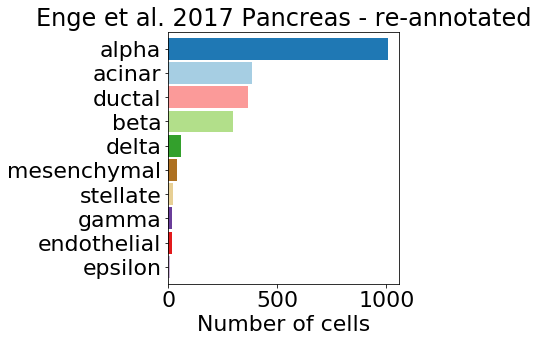

In [44]:
keys = atlas_avg_metadata.sort_index(ascending=True).index
values = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+sns.color_palette('BrBG',5)[:2]
lut = dict(zip(keys,values))
colors = atlas_avg_metadata.sort_values('number_of_cells').index.map(lut)

f = plt.figure(figsize=(8,5))
atlas_avg_metadata.sort_values('number_of_cells')['number_of_cells'].plot.barh(width=.9,color=colors,legend=False)
plt.xlabel('Number of cells')
plt.title('Enge et al. 2017 Pancreas - re-annotated')
plt.gcf().subplots_adjust(left=.35,right=0.75,bottom=.2,top=.9)
f.savefig(output_dir+'Atlas_data_original_cellNumBarh.png')
f.savefig(output_dir+'Atlas_data_original_cellNumBarh.pdf')
plt.show()

# first round of annotation

In [9]:
# set date - this will allow creation of a subfolder within save_dir with this timestamp
date = time.datenum_complete()

In [10]:
imp.reload(noa)

<module 'northstar_analysis' from '/Users/bojk/Google Drive/QuakeLab/northstar_analysis/modules/northstar_analysis.py'>

In [14]:
kwds = {
    'atlas':'Enge_2017_reannotated',
    'n_features_per_cell_type':90,#90
    'n_features_overdispersed':5,#5
    'n_pcs':20,
    'n_neighbors':5,
    'n_neighbors_out_of_atlas':5,
    'weights_atlas_cells':20,
    'threshold_neighborhood':0.8,
    'resolution_parameter':0.002,
    'timestamp':date,
    'savedir':output_dir,
}

tsnedf, celltypes, distance_matrix = noa.atlas_averages_to_tsnedf(TuPa_meta, TuPa_counttable, **kwds)

-------------------------------------------
Instantiating Northstar
-------------------------------------------
re-annotating with Northstar using atlas averages...
Atlas used: Enge_2017_reannotated
annotation done.
-------------------------------------------
performing PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------
-------------------------------------------
writing parameters to file, time stamp: 20191014212334
writing feature selected matrix to file...
done
-------------------------------------------


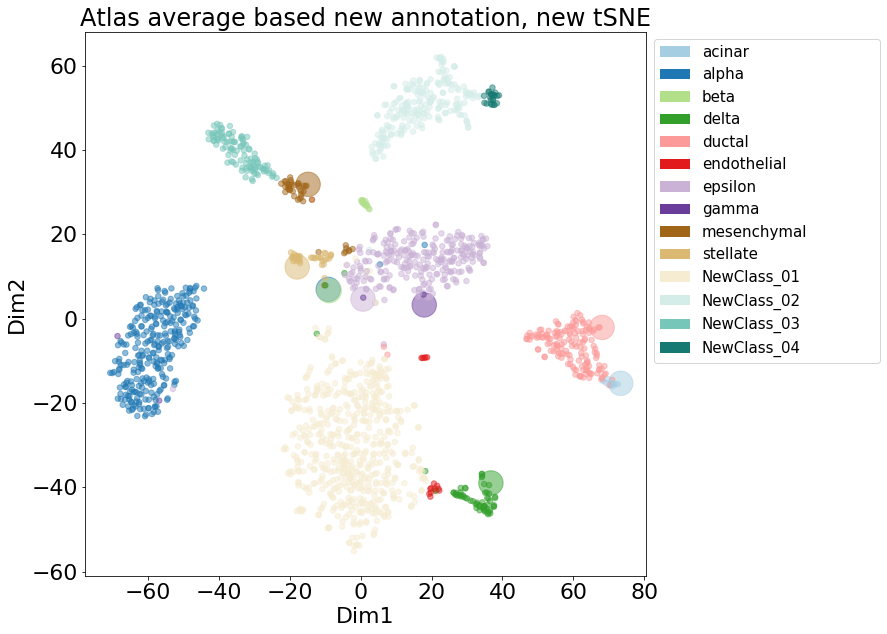

In [15]:
addl = len(celltypes)-8
if (addl % 2 == 0):
    added_colors = sns.color_palette('BrBG',addl)
    colors = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+added_colors
elif addl>2:
    all_colors = sns.color_palette('BrBG',addl+1)
    mid = round((len(all_colors)-1)/2)
    added_colors = all_colors[:mid]+all_colors[mid+1:]
    colors = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+added_colors
else:
    added_colors = sns.color_palette('BrBG',3)[0]
    colors = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+[added_colors]
mainlut = dict(zip(celltypes,colors))
newcolor = tsnedf['new_membership'].map(mainlut)
weights = list(np.ones(9)*kwds['weights_atlas_cells']*30)+list(np.ones(len(tsnedf[9:]))*30)

f,ax = plt.subplots(figsize=(12,10))
tsnedf.plot.scatter('Dim1','Dim2',s=weights,color=newcolor,alpha=.5,ax=ax)
for x,y in mainlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,celltypes,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Atlas average based new annotation, new tSNE')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(output_dir+date+'/Figure_3A_S6TopLeft.png')
f.savefig(output_dir+date+'/Figure_3A_S6TopLeft.pdf')
plt.show()

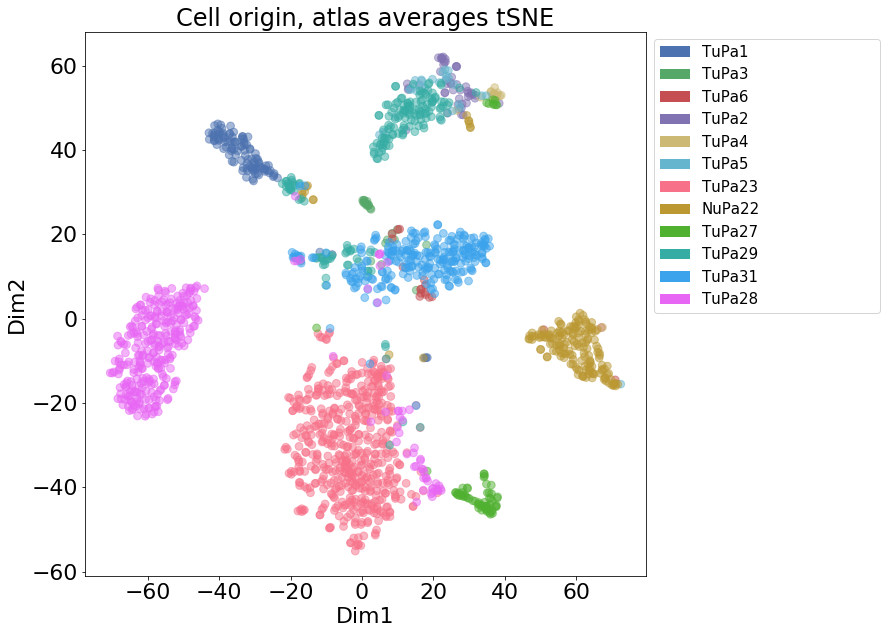

In [16]:
atlas_ct = [f for f in celltypes if 'newClass' not in f]
num_AtlasCells = len(atlas_ct)
keys = TuPa_meta['Tumor'].unique()
TuPalut = dict(zip(keys,sns.color_palette('deep', len(keys)-6)+sns.color_palette('husl',6)))
TuPacolor = TuPa_meta['Tumor'].map(TuPalut)
f,ax = plt.subplots(figsize=(12,10))
tsnedf[num_AtlasCells:].plot.scatter('Dim1','Dim2',s=60
                    ,alpha=.5,color=TuPacolor.loc[tsnedf[num_AtlasCells:].index],ax=ax)
for x,y in TuPalut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Cell origin, atlas averages tSNE')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(output_dir+date+'/Figure_S6_bottom_left.pdf')
f.savefig(output_dir+date+'/Figure_S6_bottom_left.png')
plt.show()

In [11]:
AT[AT.index.isin(['Zanini_2018','Baron_2016'])]

Species Technology    Tissue   Ages  \
Name                                                    
Baron_2016   Homo sapiens     InDrop  pancreas  adult   
Zanini_2018  Homo sapiens  SmartSeq2     blood  adult   

                                       Reference  \
Name                                               
Baron_2016      Baron et al. Cell Systems (2016)   
Zanini_2018  Zanini, Robinson et al. PNAS (2018)   

                                                   URL_average  \
Name                                                             
Baron_2016   https://github.com/iosonofabio/atlas_averages/...   
Zanini_2018  https://github.com/iosonofabio/atlas_averages/...   

                                                 URL_subsample Notes  
Name                                                                  
Baron_2016   https://github.com/iosonofabio/atlas_averages/...   NaN  
Zanini_2018  https://github.com/iosonofabio/atlas_averages/...   NaN

In [45]:
zanini_atlas = no.fetch_atlas('Zanini_2018',kind='average')
baron_atlas = no.fetch_atlas('Baron_2016',kind='average')
zanini_meta = pd.DataFrame(zanini_atlas['number_of_cells']).rename(index=str,columns={0:'number_of_cells'})
baron_meta = pd.DataFrame(baron_atlas['number_of_cells']).rename(index=str,columns={0:'number_of_cells'})

In [46]:
baron_meta

number_of_cells
acinar                          956
beta                           2030
delta                           500
activated_stellate              232
ductal                          797
alpha                          2042
epsilon                          17
gamma                           192
endothelial                     245
quiescent_stellate              168
macrophage                       45
schwann                          12
mast                             24
t_cell                            6

In [47]:
imp.reload(noa)
enge_ct = list(atlas_avg_metadata.index)
baron_ct = ['macrophage','t_cell']
zanini_ct = ['T cell','pDC','B cell']

kwds = {
    'atlas':[{'atlas_name':'Enge_2017_reannotated','cell_types':['alpha','beta']},
           {'atlas_name':'Zanini_2018',"cell_types":zanini_ct},
            {'atlas_name':'Baron_2016',"cell_types":baron_ct}],
    'n_features_per_cell_type':90,#90
    'n_features_overdispersed':5,#5
    'n_pcs':20,
    'n_neighbors':5,
    'n_neighbors_out_of_atlas':5,
    'weights_atlas_cells':20,
    'threshold_neighborhood':0.8,
    'resolution_parameter':0.002,
    'timestamp':date,
    'savedir':output_dir,
}

tsnedf_multi, celltypes_multi, dm_multi = noa.atlas_averages_to_tsnedf(TuPa_meta, 
                                                                       TuPa_counttable, 
                                                                       **kwds
                                                                      )

-------------------------------------------
Instantiating Northstar
-------------------------------------------
re-annotating with Northstar using atlas averages...


ValueError: atlas must be a dict

Index(['alpha', 'delta', 'beta', 'acinar', 'epsilon', 'ductal', 'stellate',
       'mesenchymal', 'gamma', 'endothelial'],
      dtype='object')

In [187]:
feature_selected_matrix = pd.read_csv(output_dir+date+'/feature_selected_matrix_'+date+'.csv',index_col=0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2


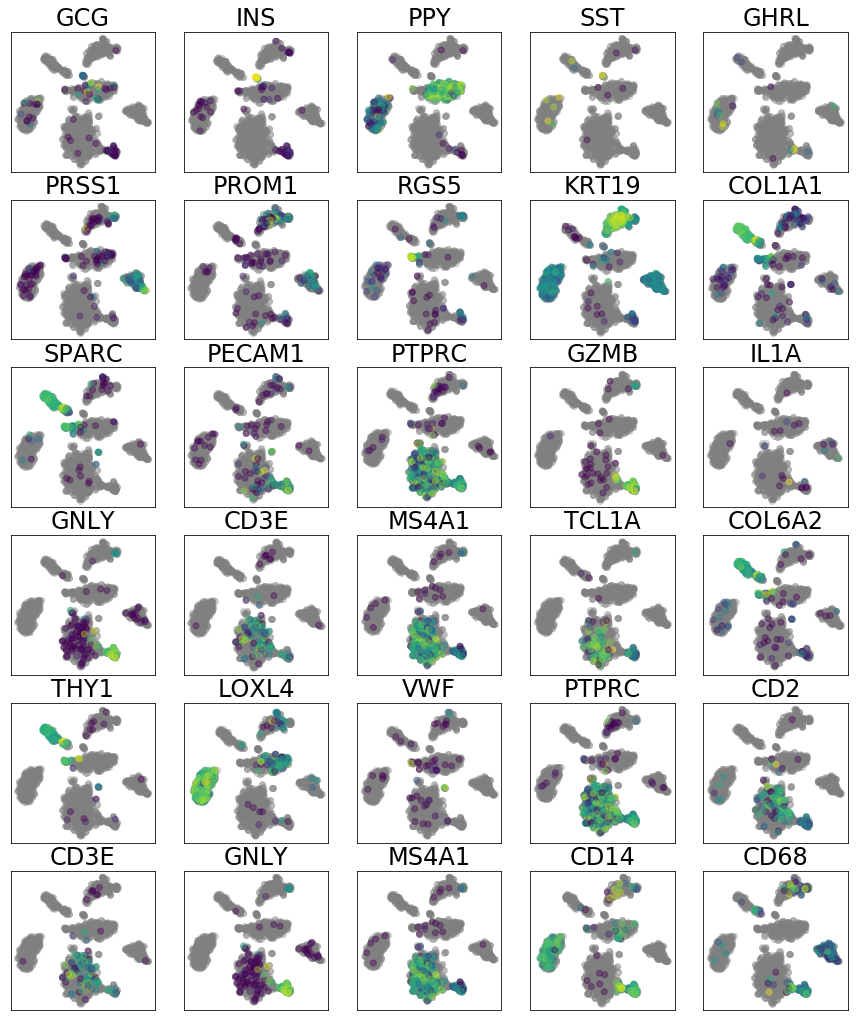

In [199]:
f,ax = plt.subplots(6,5,figsize=(15,18))
ax = ax.ravel()

types = ['alpha','beta','gamma','delta','epsilon','acinar','ductal','stellate','endo','mesenchymal']
#key_markers = ['GCG','INS','PPY','SST','GHRL','PRSS1','PROM1','RGS5','KRT19',
#               'COL1A1','SPARC','PECAM1','PTPRC','GZMB','IL1A','GNLY','CD3E','MS4A1','TCL1A']
key_markers = ['GCG','INS','PPY','SST','GHRL','PRSS1','PROM1','RGS5','KRT19',
               'COL1A1','SPARC','PECAM1','PTPRC','GZMB','IL1A','GNLY','CD3E','MS4A1'
               ,'TCL1A','COL6A2','THY1','LOXL4','VWF','PTPRC','CD2','CD3E','GNLY','MS4A1'
               ,'CD14','CD68']
               
               #,'PDGFRA','PDGFRB','COL13A1','COL14A1','ISL1']

for i in range(len(key_markers)):
    gene = key_markers[i]
    #TuPa_meta[gene] = TuPa_counttable.loc[gene].divide(TuPa_meta['nReads'])
    ax[i].scatter(tsnedf.iloc[num_AtlasCells:]['Dim1'],tsnedf.iloc[num_AtlasCells:]['Dim2'],c='gray',alpha=.3)
    ax[i].scatter(tsnedf.iloc[num_AtlasCells:]['Dim1'],tsnedf.iloc[num_AtlasCells:]['Dim2'],cmap='viridis',alpha=.4,c=np.log2(TuPa_counttable.loc[gene,tsnedf[num_AtlasCells:].index]))
    ax[i].set_title(gene)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    """ax[i].set_xlim(right=65)
    ax[i].set_ylim(bottom=-60)"""
    
#f.savefig(savedir+date+'/Figure_S4_key_marker_genes.png')
#f.savefig(savedir+date+'/Figure_S4_key_marker_genes.pdf')
plt.show()

# Subsampling-based annotation

In [210]:
imp.reload(noa)

<module 'northstar_analysis' from '/Users/bojk/Google Drive/QuakeLab/northstar_analysis/modules/northstar_analysis.py'>

In [211]:
kwds = {
    'atlas':'Enge_2017_reannotated',
    'n_features_per_cell_type':90,
    'n_features_overdispersed':5,
    'n_pcs':20,
    'n_neighbors':5,
    'n_neighbors_out_of_atlas':5,
    'weights_atlas_cells':20,
    'threshold_neighborhood':0.8,
    'resolution_parameter':0.001,
    'timestamp':date,
    'savedir':output_dir,
}

tsnedf_sub, celltypes_sub = noa.atlas_subsamples_to_tsnedf(TuPa_meta, TuPa_counttable, **kwds)

-------------------------------------------
intantiating Northstar
-------------------------------------------
re-annotating with Northstar using atlas subsamples...
Atlas used: Enge_2017_reannotated
annotation done.
-------------------------------------------
performing PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------
-------------------------------------------
writing parameters to file, time stamp: 20190921115830
done
-------------------------------------------


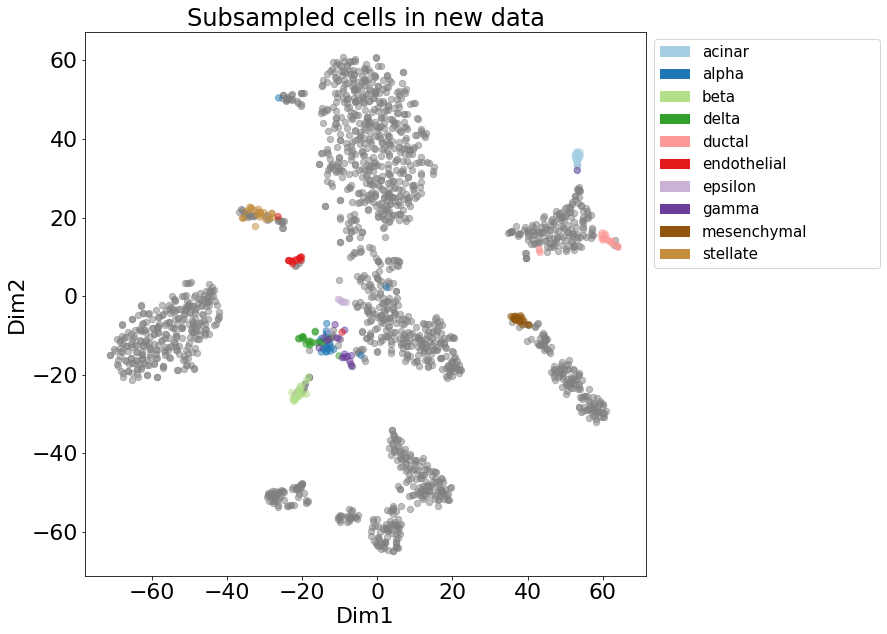

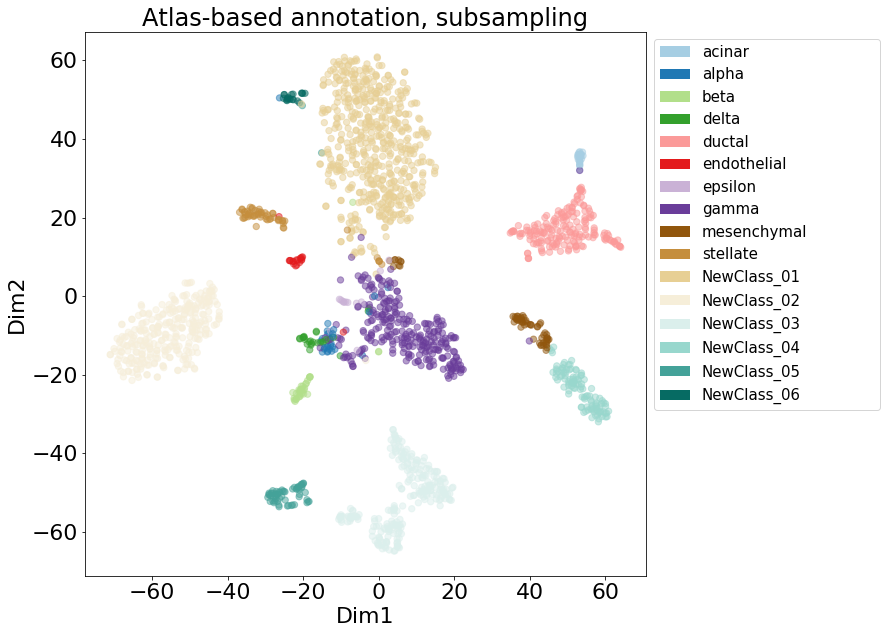

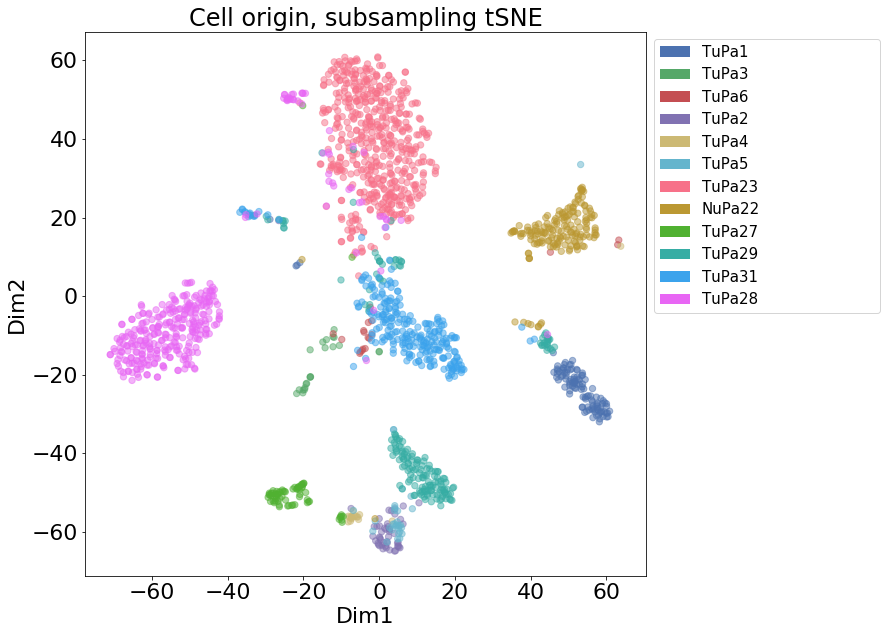

In [221]:
addl = len(celltypes_sub)-8
if addl % 2 == 0:
    added_colors = sns.color_palette('BrBG',addl)
else:
    all_colors = sns.color_palette('BrBG',addl+1)
    mid = round((len(all_colors)-1)/2)
    added_colors = all_colors[:mid]+all_colors[mid+1:]
colors = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+added_colors


newlut = dict(zip(celltypes_sub,colors))
newcolor = tsnedf_sub['new_membership'].map(newlut)
sub_cells = len(tsnedf_sub)-len(TuPa_meta)

f,ax = plt.subplots(figsize=(12,10))
tsnedf_sub[sub_cells:].plot.scatter('Dim1','Dim2',s=40
                    ,alpha=.5,color='gray',ax=ax)
tsnedf_sub[:sub_cells].plot.scatter('Dim1','Dim2',s=40
                    ,alpha=.5,color=newcolor[:sub_cells],ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
handles, labels = ax.get_legend_handles_labels()
atlas_cells = [f for f in celltypes_sub if 'NewClass' not in f]
plt.legend(handles,atlas_cells,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Subsampled cells in new data')
plt.gcf().subplots_adjust(left=.1,right=0.75)
#f.savefig(output_dir+date+'/Figure_S3_topLeft.png')
#f.savefig(output_dir+date+'/Figure_S3_topLeft.pdf')

f,ax = plt.subplots(figsize=(12,10))
tsnedf_sub.plot.scatter('Dim1','Dim2',s=40
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles,celltypes_sub
           ,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Atlas-based annotation, subsampling')
plt.gcf().subplots_adjust(left=.1,right=0.75)
#f.savefig(output_dir+date+'/Figure_S3_topRight.png')
#f.savefig(output_dir+date+'/Figure_S3_topRight.pdf')
plt.show()




f,ax = plt.subplots(figsize=(12,10))
new_cells = TuPacolor.index
tsnedf_sub.loc[new_cells].plot.scatter('Dim1','Dim2',s=40
                    ,alpha=.5,color=TuPacolor,ax=ax)
for x,y in TuPalut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles,labels
           ,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Cell origin, subsampling tSNE')
plt.gcf().subplots_adjust(left=.1,right=0.75)
#f.savefig(output_dir+date+'/Figure_S3_topRight.png')
#f.savefig(output_dir+date+'/Figure_S3_topRight.pdf')
plt.show()

# Multi-atlas based annotation of subclusters

In [109]:
set(tsnedf['new_membership'].unique()).difference(mainlut.keys())

{'NewClass_10'}

In [115]:
addl
mid
len(added_colors)

10

In [249]:
alpha = ['GCG','LOXL4','PLCE1','IRX2','GC','KLHL41','CRYBA2','TM4SF4','RGS4']
beta = ['INS','IAPP','MAFA','NPTX2','DLK1','ADCYAP1','PFKFB2','PDX1','TGFBR3','SYT13']
delta = ['SST','PRG4','LEPR','RBP4','BCHE','HHEX','FRZB','PCSK1','RGS2','GABRG2']
gamma = ['PPY']
epsilon = ['GHRL','ISL1']

acinar = ['PRSS1']
ductal = ['PROM1','KRT19','SPARC']
stellate = ['RGS5','PDGFRA','SPARC','COL1A1']
endo = ['VWF','SPARC'] 
panendothelial = ['PECAM1','CDH5','ESAM','FLT1','KDR']
mesenchymal = ['THY1']


pdac = ['LAMC2','CTSE','GPX2','LGALS4','GPRC5A','MMP14','ITGA2','AGR2','COL17A1','TSPAN8','CEACAM7']
ict = ['SCG2','RASSF7','TTR','SGNE1','INSM1','PCSK2','QPCT','FGB','PEX7','PTPRN2','SERPINA1','ARF3']
third_clust = ['AXIN2','AXL','MAFB','MMP2','BGN','COL1A2','FN1','SPARC']

force_include = set(alpha+beta+delta+gamma+epsilon+acinar+ductal+stellate+endo+panendothelial+mesenchymal)

KOLS = ['alpha','beta','delta','gamma','PDAC','acinar','islet cell tumors','third_cluster']

In [358]:
#matrix_feature_selected.index.str.contains('PPY')

In [256]:
"""f,ax = plt.subplots(4,3,figsize=(15,20))
ax = ax.ravel()

types = ['alpha','beta','gamma','delta','epsilon','acinar','ductal','stellate','endo','mesenchymal']
key_markers = ['GCG','INS','PPY','SST','GHRL','PRSS1','PROM1','RGS5','VWF','THY1','PECAM1','SPARC']

for i in range(len(key_markers)):
    gene = key_markers[i]
    TuPa_meta[gene] = TuPa_counttable.loc[gene].divide(TuPa_meta['nReads'])
    ax[i].scatter(TuPa_meta['tSNE_1'],TuPa_meta['tSNE_2'],c='gray',alpha=.3)
    ax[i].scatter(TuPa_meta['tSNE_1'],TuPa_meta['tSNE_2'],cmap='viridis',alpha=.4,c=np.log2(TuPa_meta[gene]))
    ax[i].set_title(gene)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
#f.savefig(savedir+date+'/key_pancreatic_marker_genes.png')
#f.savefig(savedir+date+'/key_pancreatic_marker_genes.pdf')
#ax[-1].scatter(TuPa_meta['tSNE_1'],TuPa_meta['tSNE_2'],c='b',alpha=.6)
    

"""

"f,ax = plt.subplots(4,3,figsize=(15,20))\nax = ax.ravel()\n\ntypes = ['alpha','beta','gamma','delta','epsilon','acinar','ductal','stellate','endo','mesenchymal']\nkey_markers = ['GCG','INS','PPY','SST','GHRL','PRSS1','PROM1','RGS5','VWF','THY1','PECAM1','SPARC']\n\nfor i in range(len(key_markers)):\n    gene = key_markers[i]\n    TuPa_meta[gene] = TuPa_counttable.loc[gene].divide(TuPa_meta['nReads'])\n    ax[i].scatter(TuPa_meta['tSNE_1'],TuPa_meta['tSNE_2'],c='gray',alpha=.3)\n    ax[i].scatter(TuPa_meta['tSNE_1'],TuPa_meta['tSNE_2'],cmap='viridis',alpha=.4,c=np.log2(TuPa_meta[gene]))\n    ax[i].set_title(gene)\n    ax[i].set_xticks([])\n    ax[i].set_yticks([])\n#f.savefig(savedir+date+'/key_pancreatic_marker_genes.png')\n#f.savefig(savedir+date+'/key_pancreatic_marker_genes.pdf')\n#ax[-1].scatter(TuPa_meta['tSNE_1'],TuPa_meta['tSNE_2'],c='b',alpha=.6)\n    \n\n"

# no self-edging

In [7]:
AA_counttable.sum().head(10)

X1000010011.A01    263313.0
X1000010011.A02    210189.0
X1000010011.A03    346236.0
X1000010011.A04    136211.0
X1000010011.A05    320666.0
X1000010011.A06    372732.0
X1000010011.A07    447263.0
X1000010011.A08    499603.0
X1000010011.A09    362927.0
X1000010011.A10    531050.0
dtype: float64

In [9]:
#AA_newmeta[['total_reads','mapped_reads','n_reads']].head()

In [11]:
#AA_meta2['celltypes'] = AA_meta2['man_annot2']
AA_meta2_test =pd.read_csv(savedir+'manual_annotation_EngePancreas.csv').set_index('Unnamed: 0')
imp.reload(sam)
atlasgenes = 60
atlasweights = 20

keys = ['cell type column','number of features cell type','number of features new data'
        ,'weights_atlas_cells','timestamp','savedir']
values = ['celltypes',atlasgenes,10,atlasweights,date,savedir]
kwds = dict(zip(keys,values))
matrix,weights, AA_newmeta,TuPa_meta = sam.normmerge_twoCounttables(AA_counttable,
                                                                             AA_meta2_test, TuPa_counttable, TuPa_meta, **kwds)
matrix_feature_selected = sam.feature_select(matrix.dropna(how='all',axis=1),AA_meta2_test,**kwds)
#matrix_feature_selected =  matrix_feature_selected.append(matrix.loc[unionab.difference(set(matrix_feature_selected.index))].copy())

-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', 'ERCC-00012', 'ERCC-00013', 'ERCC-00014', 'ERCC-00016', 'ERCC-00017', 'ERCC-00019', 'ERCC-00022', 'ERCC-00024', 'ERCC-00025', 'ERCC-00028', 'ERCC-00031', 'ERCC-00033', 'ERCC-00034', 'ERCC-00035', 'ERCC-00039', 'ERCC-00040', 'ERCC-00041', 'ERCC-00042', 'ERCC-00043', 'ERCC-00044', 'ERCC-00046', 'ERCC-00048', 'ERCC-00051', 'ERCC-00053', 'ERCC-00054', 'ERCC-00057', 'ERCC-00058', 'ERCC-00059', 'ERCC-00060', 'ERCC-00061', 'ERCC-00062', 'ERCC-00067', 'ERCC-00069', 'ERCC-00071', 'ERCC-00073', 'ERCC-00074', 'ERCC-00075', 'ERCC-00076', 'ERCC-00077', 'ERCC-00078', 'ERCC-00079', 'ERCC-00081', 'ERCC-00083', 'ERCC-00084', 'ERCC-00085', 'ERCC-00086', 'ERCC-00092', 'ERCC-00095', 'ERCC-00096', 'ERCC-00097', 'ERCC-00098', 'ERCC-00099', 'ERCC-00104', 'ERCC-00108', 'ERCC-00109', 'ERCC-00111', 'ERCC-00112', 'ERCC-00113', 'ERCC-00116', 'ERCC-00117', 'ERCC-00

-------------------------------------------
Cell types in atlas:
['acinar' 'alpha' 'beta' 'delta' 'ductal' 'endothelial' 'epsilon' 'gamma'
 'mesenchymal' 'stellate']
-------------------------------------------
Cell types in new data:
[nan]
-------------------------------------------
-------------------------------------------
Selected number of genes from atlas:
600
-------------------------------------------
Selected number of genes from new cells:
10
-------------------------------------------
Combined total of selected genes:
603
-------------------------------------------


In [12]:
imp.reload(sam)
kwds['threshold_neigborhood'] = thresn = .8
kwds['n_pcs'] = n_pcs = 20 
kwds['resolution_parameter'] = respar = .015
kwds['self_edging'] = False
kwds['select_features']=False

tsnedf, class_numbers,class_labels,distmat = sam.semiAnnotate_to_pca_to_tsnedf(matrix_feature_selected,weights,AA_meta2_test,TuPa_meta,**kwds)

-------------------------------------------
performing UNweighted PCA
-------------------------------------------
perfoming tSNE
tSNE done.
-------------------------------------------


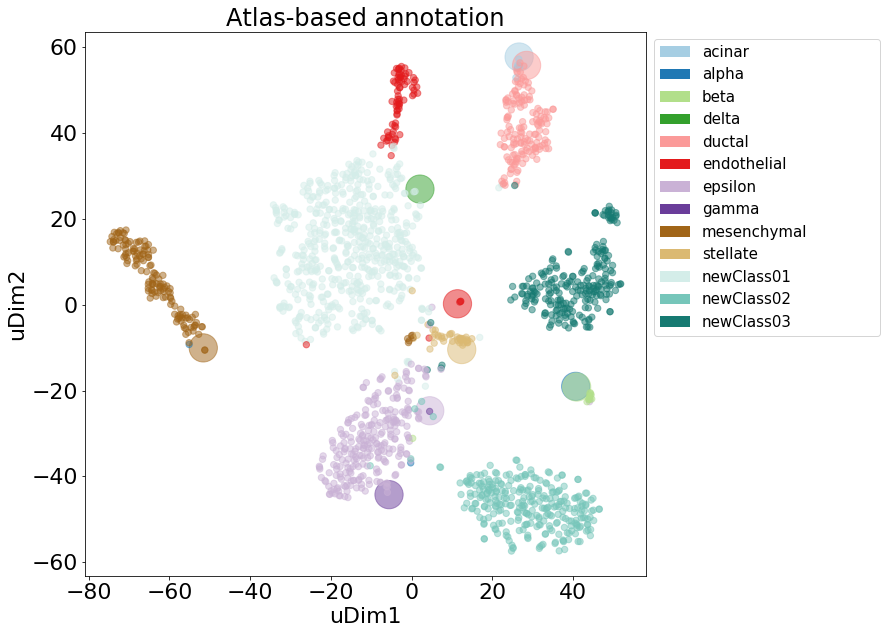

In [13]:
if (len(class_labels)-8) % 2 == 0:
    added_colors = sns.color_palette('BrBG',len(class_labels)-8)
else:
    all_colors = sns.color_palette('BrBG',len(class_labels)-7)
    mid = round((len(all_colors)-1)/2)
    added_colors = all_colors[:mid]+all_colors[mid+1:]
    
values = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+added_colors
newlut = dict(zip(class_numbers,values))
newcolor = tsnedf['class'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
tsnedf.plot.scatter('uDim1','uDim2',s=weights*40
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,class_labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Atlas-based annotation')
#plt.xlim(right=65)
#plt.ylim(bottom=-60)
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(savedir+date+'/sA_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig(savedir+date+'/sA_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

In [853]:
#tsnedf

In [854]:
tsnedf.new_membership.value_counts()

newClass01     562
newClass02     298
epsilon        263
newClass03     230
ductal         163
mesenchymal    148
endothelial     82
stellate        38
beta            13
alpha            3
acinar           2
gamma            2
delta            1
Name: new_membership, dtype: int64

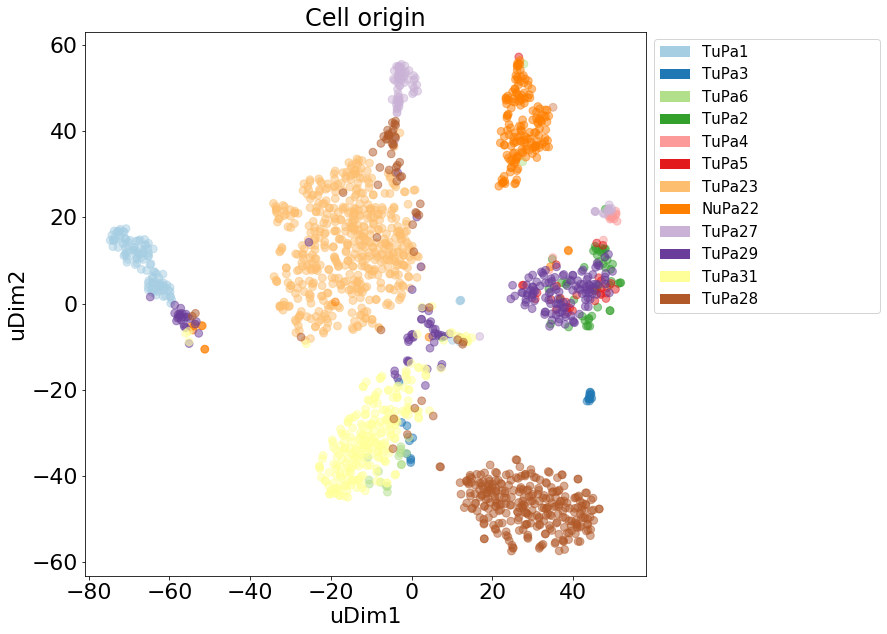

In [855]:
keys = TuPa_meta['Tumor'].unique()
newlut = dict(zip(keys,sns.color_palette('Paired', len(keys))))
newcolor = TuPa_meta['Tumor'].map(newlut)
f,ax = plt.subplots(figsize=(12,10))
tsnedf[10:].plot.scatter('uDim1','uDim2',s=60
                    ,alpha=.5,color=newcolor.loc[tsnedf[10:].index],ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Cell origin')
plt.gcf().subplots_adjust(left=.1,right=0.75)
"""plt.ylim(bottom=-60)
plt.xlim(right=65)"""
f.savefig(savedir+date+'/TumorPatients_newtSNE.pdf')
f.savefig(savedir+date+'/TumorPatients_newtSNE.png')

/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':


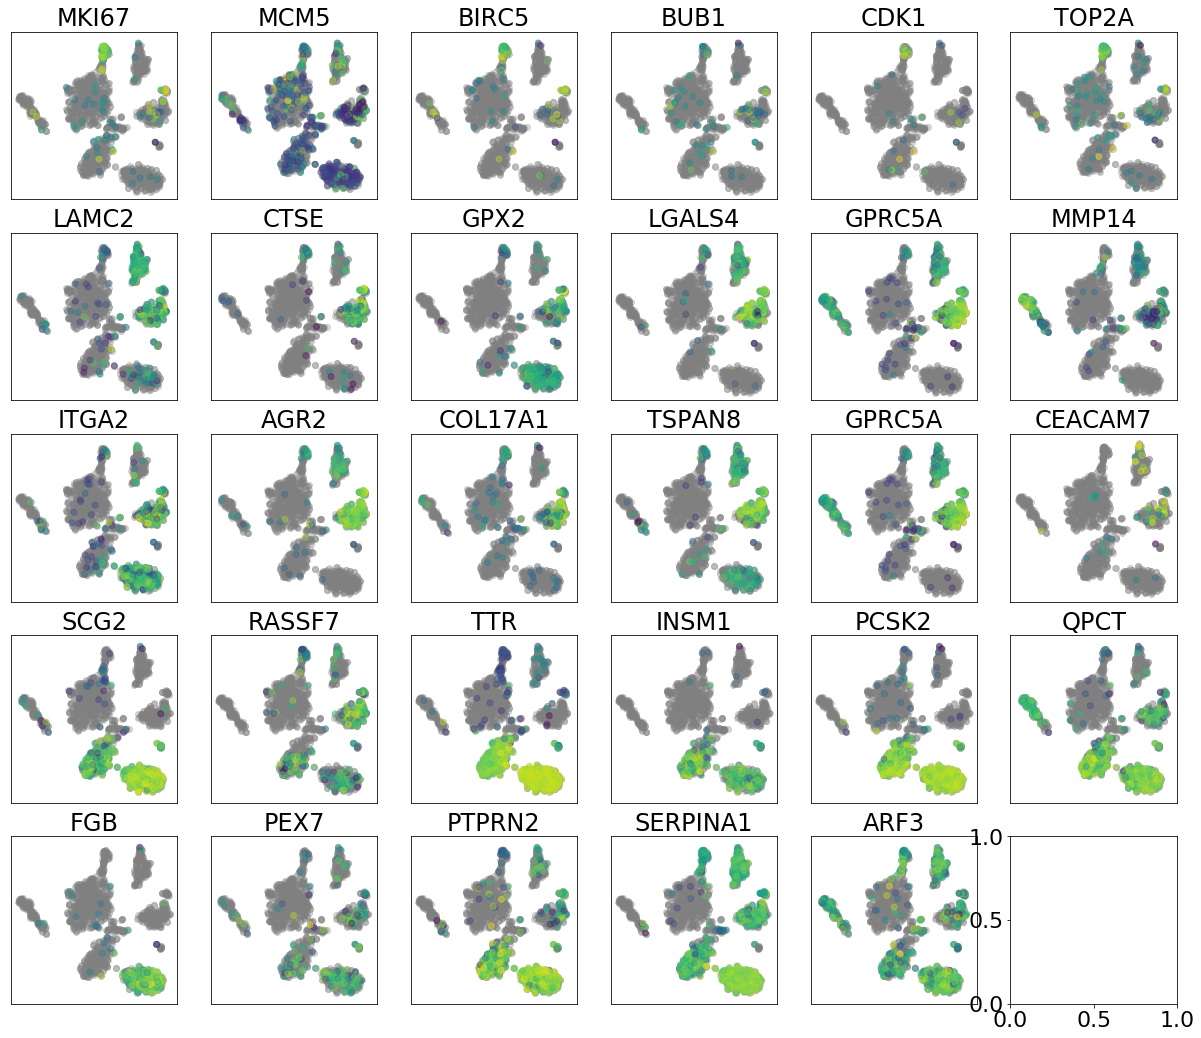

In [876]:
adino = ['LAMC2','CTSE','GPX2','LGALS4','GPRC5A','MMP14','ITGA2','AGR2','COL17A1','TSPAN8','GPRC5A','CEACAM7']
islet = ['SCG2','RASSF7','TTR','INSM1','PCSK2','QPCT','FGB','PEX7','PTPRN2','SERPINA1','ARF3'] #,'SGNE1'
cancer_markers = ['MKI67','MCM5','BIRC5','BUB1','CDK1','TOP2A']+adino+islet


f,ax = plt.subplots(5,6,figsize=(18,15))
ax = ax.ravel()
for i in range(len(cancer_markers)):
    gene = cancer_markers[i]
    #TuPa_meta[gene] = TuPa_counttable.loc[gene].divide(TuPa_meta['nReads'])
    ax[i].scatter(tsnedf['uDim1'],tsnedf['uDim2'],c='gray',alpha=.3)
    ax[i].scatter(tsnedf['uDim1'],tsnedf['uDim2'],cmap='viridis',alpha=.4,c=np.log2(matrix.loc[gene]))
    ax[i].set_title(gene)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    """ax[i].set_xlim(right=65)
    ax[i].set_ylim(bottom=-60)"""
plt.gcf().subplots_adjust(left=.05,right=0.95,top=.95,bottom=.05)
f.savefig(savedir+date+'/key_pancreatic_cancer_marker_genes_tsnedf.png')
f.savefig(savedir+date+'/key_pancreatic_cancer_marker_genes_tsnedf.pdf')

In [857]:
"""keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top1'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel1,roSE,coSE,genes_OD1,avg1 = sdot.make_dotplot(matrix_feature_selected,tsnedf,1,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top2'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel2,roSE,coSE,genes_OD2,avg2 = sdot.make_dotplot(matrix_feature_selected,tsnedf,2,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top3'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel3,roSE,coSE,genes_OD3,avg3 = sdot.make_dotplot(matrix_feature_selected,tsnedf,3,**kw)"""

"""keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top5'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel5,roSE,coSE,genes_OD5,avg3 = sdot.make_dotplot(matrix_feature_selected,tsnedf,5,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top10'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel10,roSE,coSE,genes_OD10,avg3 = sdot.make_dotplot(matrix_feature_selected,tsnedf,10,**kw)
"""
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top20'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel20,roSE,coSE,genes_OD20,avg20 = sdot.make_dotplot(matrix_feature_selected,tsnedf,20,**kw)

/home/bojk/Data/minimeta_pyfiles/semiAnnotate_dotplot.py:163: RuntimeWarning: divide by zero encountered in log2
  else:
/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


In [870]:
genes_ODSU20['gamma']#.isin(islet)


0       SNORA62
1         CRYGC
2        NPFFR2
3           GGN
4      MIR137HG
5        FAM66D
6          ANO3
7         OPRM1
8         SPAG8
9       C3orf80
10       CSN1S1
11       CARTPT
12      MIR4284
13          FGB
14        UFSP1
15         NAGS
16       SUCNR1
17       PCDHA8
18      PACSIN1
19    ARHGAP11A
Name: gamma, dtype: object

In [865]:
adino = ['LAMC2','CTSE','GPX2','LGALS4','GPRC5A','MMP14','ITGA2','AGR2','COL17A1','TSPAN8','GPRC5A','CEACAM7']
islet = ['SCG2','RASSF7','TTR','SGNE1','INSM1','PCSK2','QPCT','FGB','PEX7','PTPRN2','SERPINA1','ARF3']
for c in genes_ODSU20.columns:
    g = genes_ODSU20[genes_ODSU20[c].isin(islet)].values                      
    print(c)
    print(g)

acinar
[]
alpha
[]
beta
[]
delta
[]
ductal
[]
endothelial
[]
epsilon
[]
gamma
[['GP2' 'C7orf57' 'NAT8' 'NKAIN1' 'AGXT' 'SOX18' 'TAS2R5' 'FGB' 'APOD'
  'GPAT2' 'TMEM119' 'PPP1R14D' 'SPNS3' 'TNF' 'C5orf38']]
mesenchymal
[]
stellate
[]
newClass04
[]
newClass03
[]
newClass01
[]
newClass05
[]
newClass02
[['RBPJL' 'NNAT' 'CHST8' 'DGKB' 'FOLR1' 'VWF' 'COL2A1' 'CARTPT' 'FGF7'
  'PLCL1' 'CXCL14' 'SPINK4' 'TNF' 'HLA-DQA1' 'TTR']]


In [125]:
tsnedf['Tumor'] = TuPa_meta['Tumor']
tsnedf['count'] = 1

In [326]:
def cellTypeOccurrence(tsnedf,metadf):
    tsnedf['Tumor'] = metadf['Tumor']
    tsnedf['count'] = 1
    counts = pd.pivot_table(tsnedf,index='new_membership',columns='Tumor',values='count',aggfunc=np.sum)
    return counts

In [337]:
counts_normal.divide(counts_normal.sum()).fillna(0)

Tumor             NuPa22     TuPa1     TuPa2    TuPa23    TuPa27    TuPa28  \
new_membership                                                               
acinar          0.000000  0.000000  0.000000  0.000000  0.014706  0.000000   
alpha           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
beta            0.000000  0.000000  0.000000  0.001923  0.000000  0.000000   
delta           0.000000  0.000000  0.000000  0.001923  0.000000  0.000000   
ductal          0.930636  0.000000  0.000000  0.000000  0.000000  0.000000   
mesenchymal     0.052023  0.045455  0.020833  0.000000  0.000000  0.011561   
newClass01      0.005780  0.000000  0.000000  0.996154  0.000000  0.075145   
newClass02      0.000000  0.000000  0.000000  0.000000  0.000000  0.858382   
newClass03      0.000000  0.000000  0.000000  0.000000  0.000000  0.005780   
newClass04      0.011561  0.000000  0.979167  0.000000  0.161765  0.000000   
newClass05      0.000000  0.954545  0.000000  0.000000  0.000000  0.000000   
newClass06      0.000000  0.000000  0.000000  0.000000  0.823529  0.049133   

Tumor             TuPa29     TuPa3    TuPa31   TuPa4     TuPa5     TuPa6  
new_membership                                                            
acinar          0.000000  0.000000  0.000000  0.0000  0.000000  0.000000  
alpha           0.000000  0.000000  0.000000  0.0000  0.033333  0.000000  
beta            0.005348  0.318182  0.000000  0.0000  0.000000  0.000000  
delta           0.000000  0.000000  0.000000  0.0000  0.000000  0.000000  
ductal          0.000000  0.000000  0.000000  0.0625  0.000000  0.166667  
mesenchymal     0.262032  0.000000  0.073930  0.0000  0.000000  0.000000  
newClass01      0.074866  0.000000  0.011673  0.0000  0.033333  0.000000  
newClass02      0.000000  0.045455  0.003891  0.0000  0.000000  0.000000  
newClass03      0.005348  0.636364  0.910506  0.0000  0.000000  0.833333  
newClass04      0.652406  0.000000  0.000000  0.9375  0.933333  0.000000  
newClass05      0.000000  0.000000  0.000000  0.0000  0.000000  0.000000  
newClass06      0.000000  0.000000  0.000000  0.0000  0.000000  0.000000

new_membership  acinar  alpha  beta    ductal  endothelial   epsilon  gamma  \
Tumor                                                                         
NuPa22             NaN    NaN   NaN  0.975309     0.012346       NaN    NaN   
TuPa1              NaN    NaN   NaN       NaN     0.037037       NaN    NaN   
TuPa2              NaN    NaN   NaN       NaN          NaN       NaN    NaN   
TuPa23             NaN    NaN   NaN       NaN     0.024691       NaN    NaN   
TuPa27             NaN    NaN   NaN       NaN     0.691358       NaN    NaN   
TuPa28             NaN    NaN   NaN       NaN     0.222222  0.011450    NaN   
TuPa29             NaN    0.5   NaN       NaN          NaN  0.003817    NaN   
TuPa3              NaN    0.5   1.0       NaN          NaN  0.030534    NaN   
TuPa31             NaN    NaN   NaN       NaN     0.012346  0.896947    1.0   
TuPa4              NaN    NaN   NaN  0.006173          NaN       NaN    NaN   
TuPa5              1.0    NaN   NaN       NaN          NaN       NaN    NaN   
TuPa6              NaN    NaN   NaN  0.018519          NaN  0.057252    NaN   

new_membership  mesenchymal  newClass01  newClass02  newClass03  stellate  
Tumor                                                                      
NuPa22             0.054422    0.005338         NaN    0.013043       NaN  
TuPa1              0.714286         NaN         NaN         NaN  0.054054  
TuPa2                   NaN         NaN         NaN    0.204348  0.027027  
TuPa23                  NaN    0.921708         NaN         NaN       NaN  
TuPa27                  NaN    0.001779         NaN    0.047826       NaN  
TuPa28             0.013605    0.042705    0.993289         NaN  0.081081  
TuPa29             0.197279    0.026690         NaN    0.543478  0.432432  
TuPa3                   NaN         NaN    0.003356         NaN       NaN  
TuPa31             0.020408    0.001779    0.003356         NaN  0.405405  
TuPa4                   NaN         NaN         NaN    0.065217       NaN  
TuPa5                   NaN         NaN         NaN    0.126087       NaN  
TuPa6                   NaN         NaN         NaN         NaN       NaN

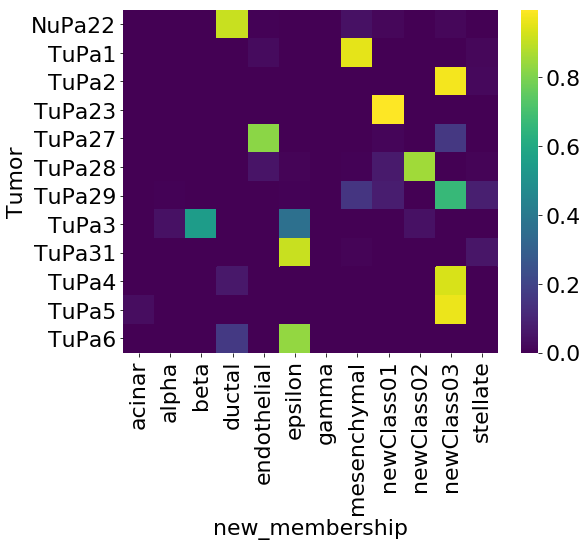

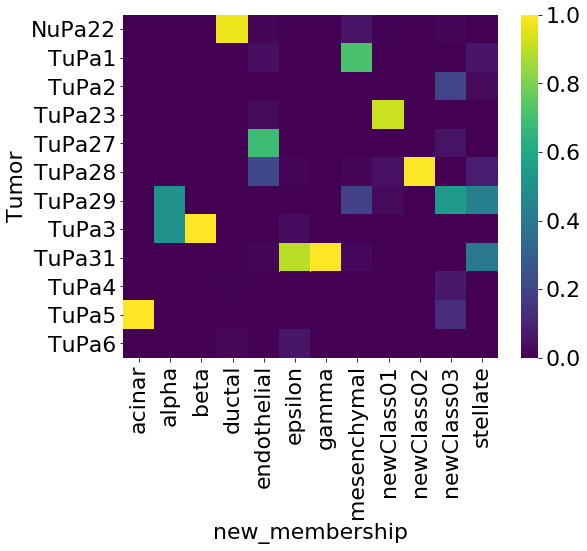

In [813]:
counts_normal = cellTypeOccurrence(tsnedf,TuPa_meta)
f = plt.figure(figsize=(10,7))
sns.heatmap(counts_normal.divide(counts_normal.sum()).fillna(0).T,cmap='viridis')
plt.gcf().subplots_adjust(left=.3,right=0.95,bottom=.2)
f.savefig(savedir+date+'/occurrence_tumor.png')

f = plt.figure(figsize=(10,7))
sns.heatmap(counts_normal.T.divide(counts_normal.sum(axis=1)).fillna(0),cmap='viridis')
plt.gcf().subplots_adjust(left=.3,right=0.95,bottom=.2)
f.savefig(savedir+date+'/occurrence_tumor_normperClass.png')

In [144]:
a.fillna(0).T.to_csv(savedir+date+'/occurrence_tumor.csv')

In [14]:
imp.reload(sam)
kwds['number_of_cells_per_type'] = 20
matrix_sub,annot,annotdict, AA_newmeta,TuPa_meta = sam.normmerge_twoCounttables_subsample(AA_counttable,
                                                                             AA_meta2_test, TuPa_counttable, TuPa_meta, **kwds)
matrix_feature_selected_sub = sam.feature_select_sub(matrix_sub.dropna(how='all',axis=1),annot,AA_meta2_test,**kwds)
#matrix??


-------------------------------------------
genes to be removed from counttable:
['BIVM-ERCC5', 'ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', 'ERCC-00012', 'ERCC-00013', 'ERCC-00014', 'ERCC-00016', 'ERCC-00017', 'ERCC-00019', 'ERCC-00022', 'ERCC-00024', 'ERCC-00025', 'ERCC-00028', 'ERCC-00031', 'ERCC-00033', 'ERCC-00034', 'ERCC-00035', 'ERCC-00039', 'ERCC-00040', 'ERCC-00041', 'ERCC-00042', 'ERCC-00043', 'ERCC-00044', 'ERCC-00046', 'ERCC-00048', 'ERCC-00051', 'ERCC-00053', 'ERCC-00054', 'ERCC-00057', 'ERCC-00058', 'ERCC-00059', 'ERCC-00060', 'ERCC-00061', 'ERCC-00062', 'ERCC-00067', 'ERCC-00069', 'ERCC-00071', 'ERCC-00073', 'ERCC-00074', 'ERCC-00075', 'ERCC-00076', 'ERCC-00077', 'ERCC-00078', 'ERCC-00079', 'ERCC-00081', 'ERCC-00083', 'ERCC-00084', 'ERCC-00085', 'ERCC-00086', 'ERCC-00092', 'ERCC-00095', 'ERCC-00096', 'ERCC-00097', 'ERCC-00098', 'ERCC-00099', 'ERCC-00104', 'ERCC-00108', 'ERCC-00109', 'ERCC-00111', 'ERCC-00112', 'ERCC-00113', 'ERCC-00116', 'ERCC-00117', 'ERCC-00

-------------------------------------------
Cell types in atlas:
['acinar' 'alpha' 'beta' 'delta' 'ductal' 'endothelial' 'epsilon' 'gamma'
 'mesenchymal' 'stellate']
-------------------------------------------
Cell types in new data:
[nan]
-------------------------------------------
200
-------------------------------------------
Selected number of genes from atlas:
600
-------------------------------------------
Selected number of genes from new cells:
10
-------------------------------------------
Combined total of selected genes:
604
-------------------------------------------


In [15]:
imp.reload(sam)
kwds['threshold_neigborhood'] = thresn = .8 
kwds['n_pcs'] = n_pcs = 20 
kwds['resolution_parameter'] = respar = .005
tsnedfSU, class_numbersSU,valsSU = sam.semiAnnotate_subsample(matrix_feature_selected_sub,annot,AA_meta2_test,TuPa_meta,**kwds)

TypeError: object of type 'numpy.int64' has no len()

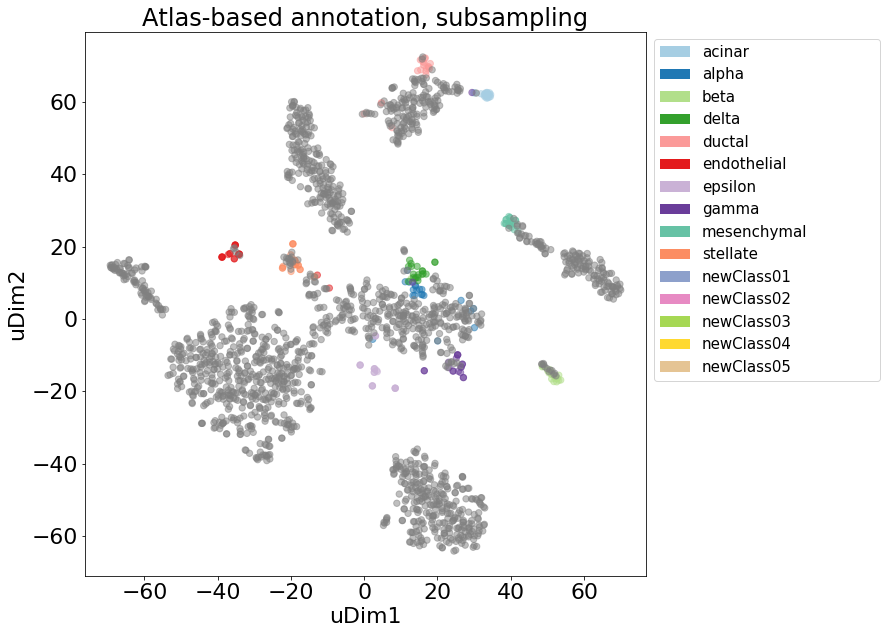

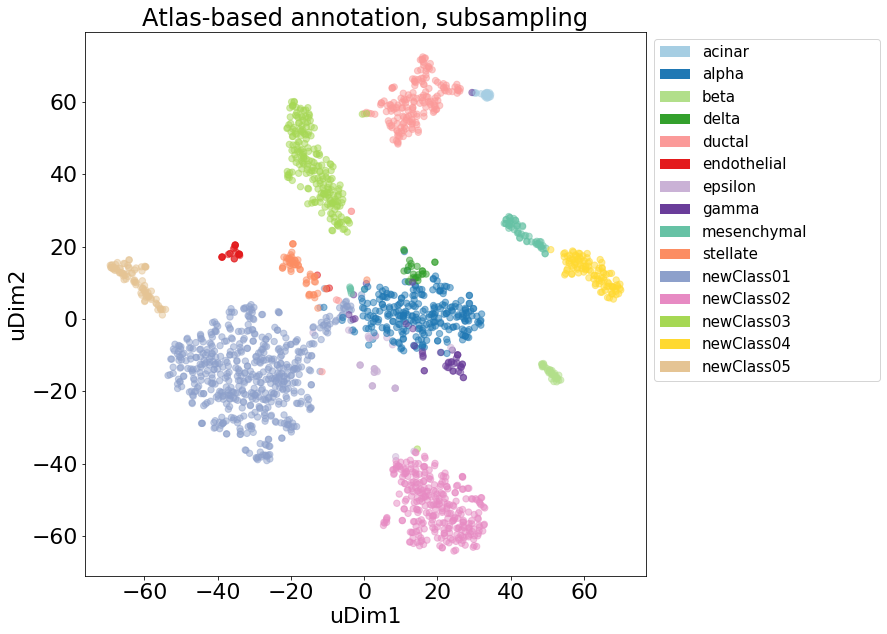

In [828]:
"""if (len(vals)-8) % 2 == 0:
    added_colors = sns.color_palette('BrBG',len(vals)-8)
else:
    all_colors = sns.color_palette('BrBG',len(vals)-7)
    mid = round((len(all_colors)-1)/2)
    added_colors = all_colors[:mid]+all_colors[mid+1:]"""
    
values = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]
disc = len(tsnedfSU['class'].unique()) - len(values)
if disc>0:
    values = values + sns.color_palette('Set2',disc)
newlut = dict(zip(valsSU,values))
newcolor = tsnedfSU['original_membership'].map(newlut).fillna('gray')

f,ax = plt.subplots(figsize=(12,10))
tsnedfSU.plot.scatter('uDim1','uDim2',s=40
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,valsSU,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Atlas-based annotation, subsampling')
#plt.xlim(right=65)
#plt.ylim(bottom=-60)
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(savedir+date+'/sA_subsampling_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig(savedir+date+'/sA_subsampling_tSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

values = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]
disc = len(tsnedfSU['class'].unique()) - len(values)
if disc>0:
    values = values + sns.color_palette('Set2',disc)
newlut = dict(zip(valsSU,values))
newcolor = tsnedfSU['new_membership'].map(newlut)#.fillna('gray')

f,ax = plt.subplots(figsize=(12,10))
tsnedfSU.plot.scatter('uDim1','uDim2',s=40
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,valsSU,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Atlas-based annotation, subsampling')
#plt.xlim(right=65)
#plt.ylim(bottom=-60)
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(savedir+date+'/sA_subsampling_tSNEcol_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig(savedir+date+'/sA_subsampling_tSNEcol_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

In [839]:
sam.semiAnnotate_subsample
import semiannotate as se
?? sam.semiannotate.Subsample()

Object ` sam.semiannotate.Subsample()` not found.


<Figure size 432x288 with 0 Axes>

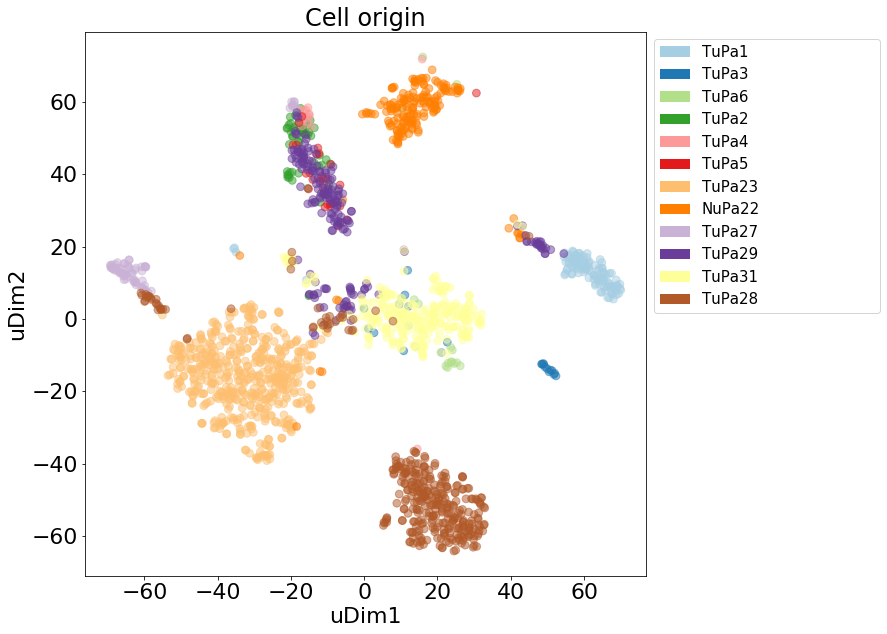

In [851]:
plt.gcf().subplots_adjust(left=.1,right=0.75)
keys = TuPa_meta['Tumor'].unique()
newlut = dict(zip(keys,sns.color_palette('Paired', len(keys))))
newcolor = TuPa_meta['Tumor'].map(newlut)
f,ax = plt.subplots(figsize=(12,10))
tsnedfSU[len(annot):].plot.scatter('uDim1','uDim2',s=60
                    ,alpha=.5,color=newcolor.loc[tsnedfSU[len(annot):].index],ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('Cell origin')
plt.gcf().subplots_adjust(left=.1,right=0.75)
"""plt.ylim(bottom=-60)
16
plt.xlim(right=65)"""
f.savefig(savedir+date+'/TumorPatients_newtSNE_subsam.pdf')
f.savefig(savedir+date+'/TumorPatients_newtSNE_subsam.png')


/home/bojk/miniconda3/envs/py360/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()


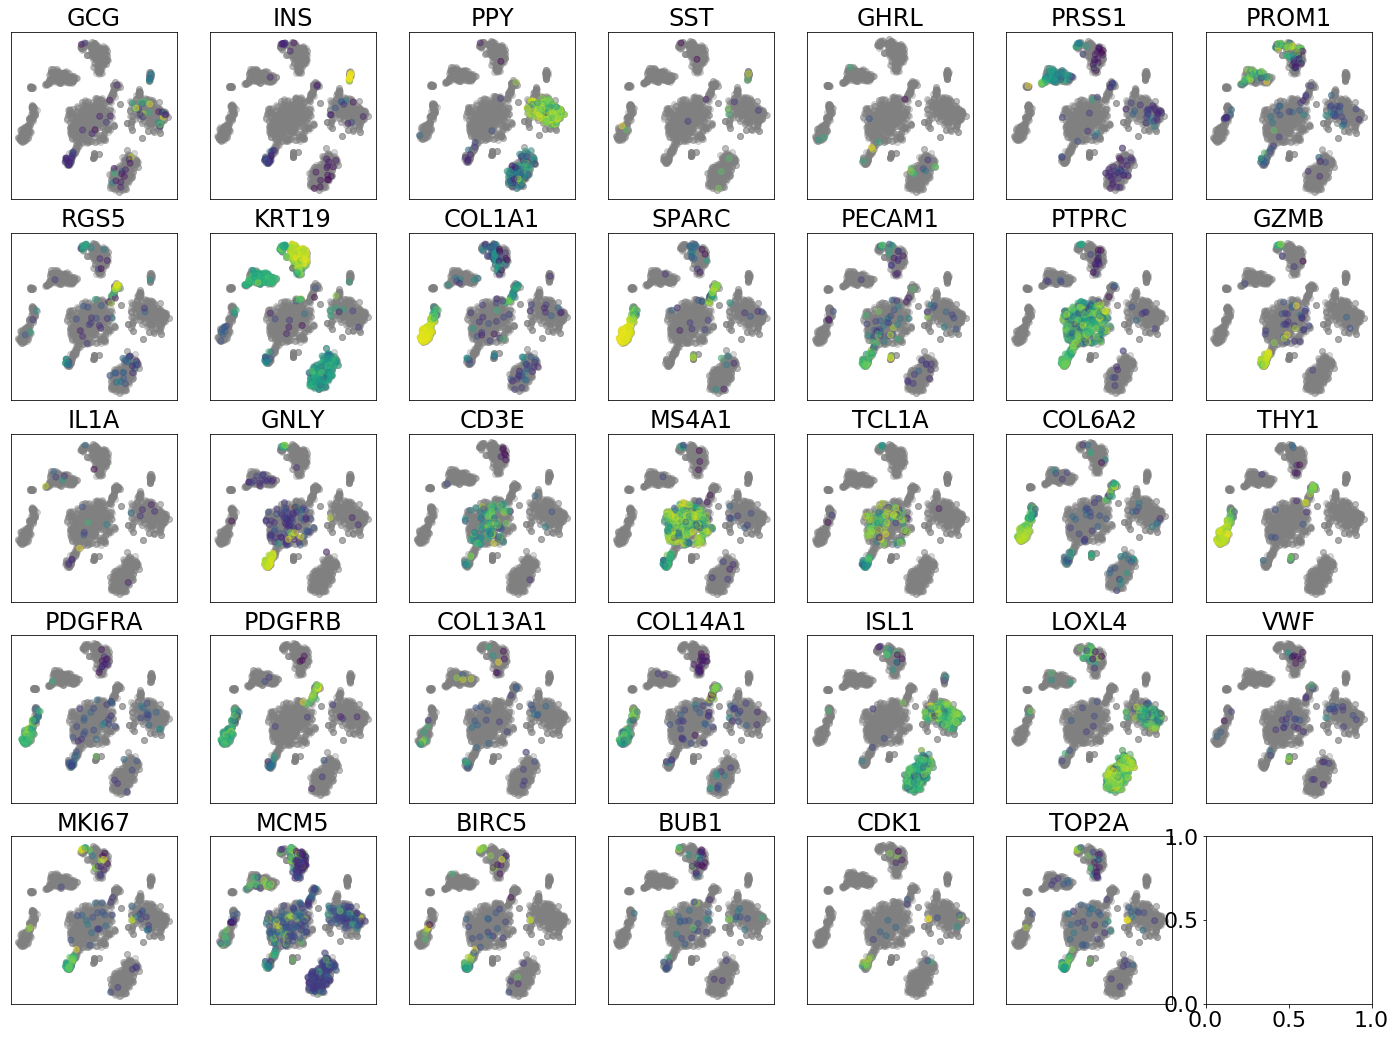

In [822]:
f,ax = plt.subplots(5,7,figsize=(21,15))
ax = ax.ravel()

types = ['alpha','beta','gamma','delta','epsilon','acinar','ductal','stellate','endo','mesenchymal']
key_markers = ['GCG','INS','PPY','SST','GHRL','PRSS1','PROM1','RGS5','KRT19',
               'COL1A1','SPARC','PECAM1','PTPRC','GZMB','IL1A','GNLY','CD3E','MS4A1','TCL1A']
key_markers = ['GCG','INS','PPY','SST','GHRL','PRSS1','PROM1','RGS5','KRT19',
               'COL1A1','SPARC','PECAM1','PTPRC','GZMB','IL1A','GNLY','CD3E','MS4A1'
               ,'TCL1A','COL6A2','THY1','PDGFRA','PDGFRB','COL13A1','COL14A1','ISL1','LOXL4','VWF', 'MKI67',
              'MCM5','BIRC5','BUB1','CDK1','TOP2A']

for i in range(len(key_markers)):
    gene = key_markers[i]
    #TuPa_meta[gene] = TuPa_counttable.loc[gene].divide(TuPa_meta['nReads'])
    ax[i].scatter(tsnedfSU['uDim1'],tsnedfSU['uDim2'],c='gray',alpha=.3)
    ax[i].scatter(tsnedfSU['uDim1'],tsnedfSU['uDim2'],cmap='viridis',alpha=.4,c=np.log2(matrix.loc[gene,tsnedfSU.index]))
    ax[i].set_title(gene)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    """ax[i].set_xlim(right=65)
    ax[i].set_ylim(bottom=-60)"""
plt.gcf().subplots_adjust(left=.05,right=0.95,top=.95,bottom=.05)
f.savefig(savedir+date+'/key_pancreatic_marker_genes_tsnedf_subsampling2.png')
f.savefig(savedir+date+'/key_pancreatic_marker_genes_tsnedf_subsampling2.pdf')

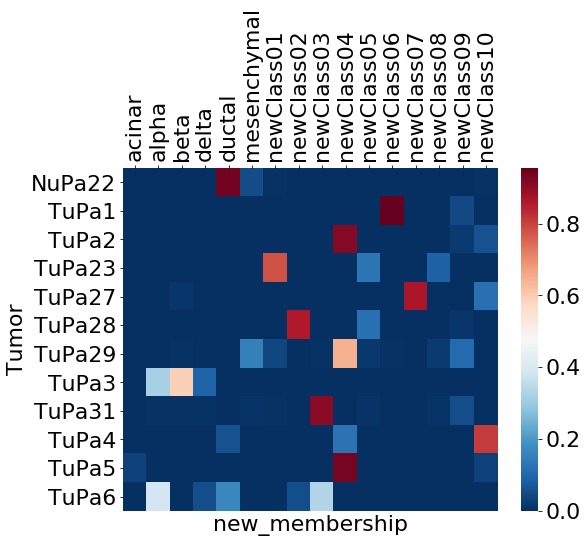

In [347]:
counts_subsamp = cellTypeOccurrence(tsnedfSU,TuPa_meta)
f = plt.figure(figsize=(10,7))
ax = sns.heatmap(counts_subsamp.divide(counts_subsamp.sum()).fillna(0).T,cmap='RdBu_r')
ax.xaxis.set_ticks_position('top')
plt.xticks(rotation=90)
plt.gcf().subplots_adjust(left=.3,right=0.95,bottom=.2)
f.savefig(savedir+date+'/occurrence_tumor_subsamp.png')

In [814]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SAsubsample_top20'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSU20,roSE,coSE,genes_ODSU20,avgSU20 = sdot.make_dotplot(matrix_feature_selected_sub,tsnedfSU,20,**kw)

In [815]:
genes_ODSU20

acinar     alpha      beta      delta    ductal endothelial  epsilon  \
0      REG3A    POPDC3       INS        SST    SPRR2A        FCN3     GHRL   
1   PNLIPRP1   FAM163A   ADCYAP1      RGS20    SPRR2E        PLP1     BHMT   
2      REG1B      BRS3      IAPP     LHFPL1    CYP1A1        ESM1    SRRM4   
3       CPA2     KCND3     HHATL   C22orf23     CXCL6     SLCO2A1    NBPF7   
4      REG3G       GCG    SLC2A2        UOX       CRP    ARHGEF15  HSD17B6   
5       CPA1    ZNF404     KCNV2      LRFN5   UGT2B15        EMCN   CCDC89   
6      CTRB2   ZCCHC18  INS-IGF2      FABP2  APOBEC3B     CD300LG      RET   
7        CEL    CACNG5  C15orf56        MAG     OTOP3         KDR     MMD2   
8     CELA3B       LPO    CAPN13    C5orf52     TTYH1       SOX17    GPR63   
9       CPB1   TAS2R10     PLCH2       DRD3       FGG       BTNL9   TYRO3P   
10     PDIA2      ZFP2      GCGR    ABCA17P      CDSN       MMRN2   GHRLOS   
11     RBPJL      NNAT     CHST8       DGKB     FOLR1         VWF   COL2A1   
12      CTRC   FAM135B   SLC35D3  PVRL3-AS1     HYAL1       GRIK3   CBX3P2   
13       GP2   C7orf57      NAT8     NKAIN1      AGXT       SOX18   TAS2R5   
14     REG1A  GLIPR1L2     DACH2      TEX12    CLDN14       THSD1    OPRK1   
15    CELA3A   C4orf36     SPAG6      P2RX2      MUC6     FAM110D    FREM2   
16      SYCN      CA10   SLC16A6       LEPR     AKAP7       RAMP3  ROCK1P1   
17     CTRB1   SYNDIG1   TAS2R13     SLAMF9    ACTBL2       ROBO4  NEUROG3   
18     AMY2A    ZNF416      MAFA  KCNJ2-AS1    FGFBP1        CDH5  SEC14L3   
19     PRSS1      INSC   MIR4269    SCGB1D2  TMPRSS13        SOX7   PCDHB9   

        gamma mesenchymal stellate newClass04 newClass03 newClass01  \
0     SNORA62       ADH1B   HIGD1B     COL1A1        PGC     PARP15   
1       CRYGC          C7    ICAM5     COL1A2    AKR1B10      CXCR4   
2      NPFFR2       CCL11      GH1     LRRC15      KRT17        CD5   
3         GGN       GSTM5     GJA4     CTHRC1     LEFTY1   HLA-DQA1   
4    MIR137HG        HAS1    CASQ2      BBOX1       AGR2     FANCD2   
5      FAM66D      GLTPD2    CSPG4      POSTN       CTSE     GIMAP7   
6        ANO3      SLC1A7   AVPR1A       RCN3      KRT23  C20orf202   
7       OPRM1    TMEM132E  FAM162B     ZNF521      VSIG2     BCL2A1   
8       SPAG8       PTGS2    GPR20       PDPN     CXCL17     IL10RA   
9     C3orf80     HSD11B1    TRPC6     ITGA11       SYT8  LINC00324   
10     CSN1S1     CYP26B1     DRD1      LAMP5       TFF1    FAM111B   
11     CARTPT        FGF7    PLCL1     CXCL14     SPINK4        TNF   
12    MIR4284        FMO2   OR51E2        MME    SLC26A9       TMC6   
13        FGB        APOD    GPAT2    TMEM119   PPP1R14D      SPNS3   
14      UFSP1       NPTX1  CYSLTR2       MMP2      MUC5B     GIMAP4   
15       NAGS     FAM180A   HAPLN2       MRC2     TRIM29      HSPB9   
16     SUCNR1        INMT    NMUR1       NKD1    PHACTR3      RCSD1   
17     PCDHA8         CPZ    FOXS1        NTM      P2RY2     MCOLN2   
18    PACSIN1         DPT    P2RX3   ADAMTS12    SULT2B1   RPL21P44   
19  ARHGAP11A      GABRR2   MIR920      THBS2       KRT7     PRDM15   

   newClass05 newClass02  
0       PTAFR   SERPIND1  
1         CFP      FSTL4  
2        FGL2      ZG16B  
3     METTL7B    SLC17A1  
4       F13A1      OVGP1  
5      BCL2A1     HMGCS2  
6      IL10RA     AMDHD1  
7      GLT1D1     GPR142  
8       PLCB2    SLC14A1  
9        ANLN     ANXA13  
10      ITGAL       AQP7  
11   HLA-DQA1        TTR  
12    FAM111B    CYP4F12  
13        TNF    C5orf38  
14      DLEU7    SLC39A5  
15       CSN3      CDH16  
16       GBP4       PRPH  
17       MFNG    SYNDIG1  
18     PECAM1     P2RY14  
19       PKLR    HSD17B2

In [156]:
len(matrix_feature_selected_sub.T)

1801

In [157]:
len(matrix.T)

1801

In [158]:
len(matrix_sub.T)

1915

In [818]:
AA_meta2_test['man_annot2'].value_counts()

alpha          1006
acinar          383
ductal          364
beta            296
delta            60
mesenchymal      40
stellate         20
gamma            18
endothelial      15
epsilon           8
Name: man_annot2, dtype: int64

In [820]:
AA_meta2_test.to_csv(savedir+'manual_annotation_EngePancreas.csv')

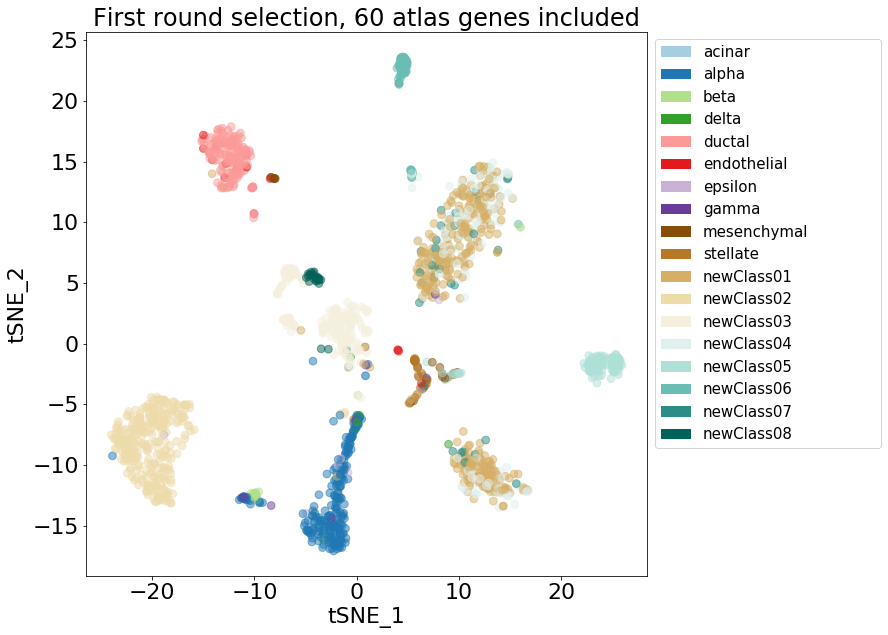

In [798]:
if (len(valsSU)-8) % 2 == 0:
    added_colors = sns.color_palette('BrBG',len(valsSU)-8)
else:
    all_colors = sns.color_palette('BrBG',len(valsSU)-7)
    mid = round((len(all_colors)-1)/2)
    added_colors = all_colors[:mid]+all_colors[mid+1:]

idx = tsnedf[10:].index
TuPa_meta.loc[idx,'new_membership'] = tsnedfSU.loc[idx,'new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(valsSU,sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired', 10)[8:10]+added_colors))
newcolor = TuPa_meta['new_membership'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
TuPa_meta.plot.scatter('tSNE_1','tSNE_2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)
f.savefig(savedir+date+'/semiAnnotate_noselfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.png')
f.savefig(savedir+date+'/semiAnnotate_noselfEdges_equalweight_origtSNE_'+date+'_nPCs='+str(n_pcs)+'_thresNeigh='+str(thresn)+'_respar='+str(respar)+'.pdf')

In [ ]:
matrix_feature_selected.to_csv(savedir+date+'/feature_selected_matrix_'+date+'.csv')
TuPa_meta.to_csv(savedir+date+'/new_cells_metadata_'+date+'.csv')
tsnedf.to_csv(savedir+date+'/tsnedf_noselfEdging_'+date+'.csv')
tsnedfSE.to_csv(savedir+date+'/tsnedf_selfEdging_'+date+'.csv')
ts.to_csv(savedir+date+'/tsnedf_selfEdging_postStab_'+date+'.csv')

In [ ]:
cluster_pair_df = sam.make_pairdf(1-average_df,2,ts)

# Dot plot creation

In [ ]:
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdes_top5'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE,roSE,coSE,genes_OD5,avg3 = sdot.make_dotplot(matrix_feature_selected,ts,5,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdes_top10'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE1,roSE,coSE,genes_OD10,avg3 = sdot.make_dotplot(matrix_feature_selected,ts,10,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdes_top15'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE,roSE,coSE,genes_OD15,avg3 = sdot.make_dotplot(matrix_feature_selected,ts,15,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdes_top20'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE,roSE,coSE,genes_OD20,avg3 = sdot.make_dotplot(matrix_feature_selected,ts,20,**kw)

In [ ]:
imp.reload(sdot)
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdes_top3'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE,roSE,coSE,genes_OD5,avg3 = sdot.make_dotplot(matrix_feature_selected,tsnedfSE,3,**kw)
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_NoSelfEgdes_top3'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanelSE,roSE,coSE,genes_OD5,avg3 = sdot.make_dotplot(matrix_feature_selected,tsnedf,3,**kw)
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_NoSelfEgdes_top5'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))

genePanelSE,roSE,coSE,genes_OD5,avg5 = sdot.make_dotplot(matrix_feature_selected,tsnedf,5,**kw)

In [ ]:
"""keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top1'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel1,roSE,coSE,genes_OD1,avg1 = sdot.make_dotplot(matrix_feature_selected,tsnedf,1,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top2'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel2,roSE,coSE,genes_OD2,avg2 = sdot.make_dotplot(matrix_feature_selected,tsnedf,2,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top3'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel3,roSE,coSE,genes_OD3,avg3 = sdot.make_dotplot(matrix_feature_selected,tsnedf,3,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top5'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel5,roSE,coSE,genes_OD5,avg3 = sdot.make_dotplot(matrix_feature_selected,tsnedf,5,**kw)

keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top10'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel10,roSE,coSE,genes_OD10,avg3 = sdot.make_dotplot(matrix_feature_selected,tsnedf,10,**kw)
"""
keys = ['left_column', 'right_column','figure_name','savedir','close_plot']
valu = ['original_membership','new_membership','pancreas_SelfEgdesSE_top20'
        ,savedir+date+'/',True]
kw = dict(zip(keys,valu))
genePanel20,roSE,coSE,genes_OD20,avg20 = sdot.make_dotplot(matrix_feature_selected,tsnedf,20,**kw)

In [ ]:
from scipy.spatial.distance import squareform
cols = genes_OD5.columns.sort_values()
index = genes_OD5[cols[0]]
for celltype in cols[1:]:
    index = index.append(genes_OD5[celltype]).reset_index(drop=True)

In [ ]:
genePanelSE.loc['INS']

In [ ]:
imp.reload(sdot)
alpha = ['GCG','LOXL4','PLCE1','IRX2','GC','KLHL41','CRYBA2','TM4SF4','RGS4']
beta = ['INS','IAPP','MAFA','NPTX2','DLK1','ADCYAP1','PFKFB2','PDX1','TGFBR3','SYT13']
delta = ['SST','PRG4','LEPR','RBP4','BCHE','HHEX','FRZB','PCSK1','RGS2','GABRG2']
KOLS = ['alpha','beta','delta']
a,b,c,avg_exp_matrix = sdot.make_top_genes(matrix_feature_selected,tsnedf,'new_membership',5)

In [ ]:
genes_OD5

In [ ]:
avg_exp_matrix.loc[alpha+beta+delta]

In [ ]:
a,b,c,avg_exp_matrix_all = sdot.make_top_genes(matrix,tsnedf,'new_membership',5)
avg_exp_matrix_all.loc[alpha+beta+delta]

In [ ]:
genes_OD20

In [ ]:
#idx = tsnedf[6:].index
#$TuPa_meta.loc[idx,'new_membership'] = tsnedf.iloc[6:]['new_membership']
# new results mapped onto old tSNE
newlut = dict(zip(vals,sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired', 10)[8:10]+sns.color_palette('BrBG',len(vals)-8)))
newcolor = TuPa_meta['new_membership'].map(newlut)

f,ax = plt.subplots(figsize=(12,10))
TuPa_meta.plot.scatter('tSNE_1','tSNE_2',s=60
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)


values = sns.color_palette('Paired', 10)[:6]+sns.color_palette('Paired',12)[8:10]+sns.color_palette('BrBG',len(class_numbers)-8)
newlut = dict(zip(class_numbers,values))
newcolor = tsnedf['class'].map(newlut)
f,ax = plt.subplots(figsize=(12,10))
tsnedf.plot.scatter('wDim1','wDim2',s=weights*40
                    ,alpha=.5,color=newcolor,ax=ax)
for x,y in newlut.items():
    plt.bar(0,0,color=y,label=x,alpha=1)
    handles, labels1 = ax.get_legend_handles_labels()
    #plt.legend(handles[:],labels[:],bbox_to_anchor=(-0.0, 1.08, 1., .102), loc=2,
plt.legend(handles,labels,bbox_to_anchor=(1, .9, .43, .102), loc=2,
               ncol=1, mode="expand",fontsize=15)
plt.title('First round selection, '+str(atlasgenes)+' atlas genes included')
plt.gcf().subplots_adjust(left=.1,right=0.75)